In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)


## Read in Protein Structure
1. We will start by reading in a set of Protein structures with the given Protein ID "pfam_id"
    * [More Info on working with PDB structures in DataFrames](http://rasbt.github.io/biopandas/tutorials/Working_with_PDB_Structures_in_DataFrames/)

In [2]:
# Read in Protein structure
data_path = 'Pfam-A.full'
pfam_id = 'PF00186'

# Set DCA_ER directory
DCA_dir = os.getcwd()

# Define data directories

# Need to think on best way to do this..
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = '%s/%s/pdb_refs.npy'%(data_path,pfam_id)
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
pdb_df.head()


number of pdb structures: 372


,PF,seq,id,uniprot_start,uniprot_start,pdb_id,chain,pdb_start,pdb_end
0,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,B,1,160
1,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,A,1,160
2,PF00186,83,Q81R22_BACAN,2,160,3JWK,B,2,160
3,PF00186,83,Q81R22_BACAN,2,160,3S9U,B,2,160
4,PF00186,83,Q81R22_BACAN,2,160,3FL9,H,2,160


PDB DataFrame needs to have PF######, PDB-id, as well as start and end locations of amino acids, as well as reference sequence in msa (not in current file with all pdb data)
### PDB Website Search Engine
   * We can visualize the complex structure of the proteins
   * The data-base below gives further information on the proteins above (input pdb_id)

### Define contact map
Import contact map functions from newly defined tools python module

In [3]:
ipdb = 0
printing = False
print('seq:',int(pdb[ipdb,1]))


# Load csv of PDB-PFAM mapping.
#    downloaded from 
#    ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/pdb_pfam_mapping.csv.gz
pdb_id = pdb_df.iloc[ipdb]['pdb_id']
pdb_chain = pdb_df.iloc[ipdb]['chain']

pdb_pfam_map_file = Path('%s/protein_data/pdb_data/pdb_pfam_mapping.csv' % DCA_dir)
pdb_map_df = pd.read_csv(pdb_pfam_map_file, sep=',', header=1)
print(pdb_map_df.head())

pdb_id_map_df = pdb_map_df.loc[pdb_map_df['PDB']==pdb_id.lower()]
pdb_pfam_map = pdb_id_map_df.loc[pdb_id_map_df['CHAIN']==pdb_chain]

# Check that pdb--pfam mapping is unique
if pdb_pfam_map.shape[0] > 1:
    print('Unable to get unique PDB-->Pfam mapping')

pp_range = [pdb_pfam_map.iloc[0]['PDB_START'], pdb_pfam_map.iloc[0]['PDB_END']]
print('Polypeptide range for contact map: ', pp_range)


seq: 69
    PDB CHAIN  PDB_START  PDB_END PFAM_ACCESSION       PFAM_NAME  \
0  101m     A          7      113        PF00042          Globin   
1  102l     A         24      149        PF00959  Phage_lysozyme   
2  102m     A          7      113        PF00042          Globin   
3  103l     A         24      151        PF00959  Phage_lysozyme   
4  103m     A          7      113        PF00042          Globin   

  AUTH_PDBRES_START AUTH_PDBRES_START_INS_CODE AUTH_PDBRES_END  \
0                 6                                        112   
1                24                                        148   
2                 6                                        112   
3                24                                        148   
4                 6                                        112   

  AUTH_PDBRES_END_INS_CODE UNIPROT_ACCESSION  UNP_START  UNP_END  
0                                     P02185          7      113  
1                                     P00720        

In [4]:

# data processing
s0,cols_removed, s_index, tpdb = data_processing(data_path, pfam_id, ipdb,\
                gap_seqs=0.2, gap_cols=0.2, prob_low=0.004, conserved_cols=0.9, printing=printing, out_dir=processed_data_dir)

pdb_out = "%s/protein_data/pdb_data" % DCA_dir
# Directory for storing PDB data locally
ct, ct_full, n_amino_full, poly_seq_curated = tools.contact_map(pdb, ipdb, pp_range, cols_removed, s_index, pdb_out_dir=pdb_out, printing=printing)



tpdb (s_ipdb) is :  69
After removing bad sequences, tpdb is now  56
Structure exists: '/home/evan/PycharmProjects/DCA_ER/protein_data/pdb_data/pdb1zdr.ent' 
length of pp_ca_coords_full  160
pdb range 0, 160
length of pp_ca_coords_full  160


3. Plot the contact Map of the imported Protein structure

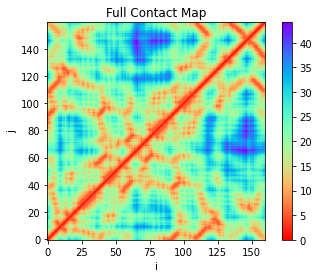

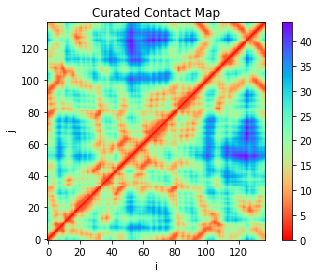

In [5]:
plt.title('Full Contact Map')
plt.imshow(ct_full,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()
tools.hide_toggle()

plt.title('Curated Contact Map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()
tools.hide_toggle()

## Now we want to use Expectation Reflection to infer the "calculate the weights " 
  * Infer interactions between residues (R-part of ammino acid) in proteins from Multiple Sequence Alignment (MSA) data
  * More understanding required on meaning/interpretation of weights
  
1. We can start by defining some important values of our protein structures
    * It is important to define 'i1i2' vector to keep track of OneHot index positions (i) coresonding to the beginning and end of a given amino acid position (this acts as a key between the OneHot matrix (s) and the original sequence matrix (s0)

In [6]:
# number of positions
n_var = s0.shape[1]
print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 137
Number of different amino acids at each position [ 6 16 12  7  8 16  8 17 12 14  9 19 11 10 13  5  5 14  9  6 11  2  9 12
 11  9 10 16 17 11 12 13  5  4  9  7 11  6  5 10 12 10  9  9 17  8  8  2
  5  2 11 11 18 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21
 19 16 16 20 15 17 13 11  8 10 12 13  4  3 13 15 12 11 13 19  9 11 17  7
 14  8 16  3 16 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 20
 19 18 21 21 19 15 17 13 16 13 14 10 14  9 18 14  5]
Total number of variables 1702


2.  The above indices help to divide all the possible amino acids at different positions to binary choices which will be implemented wit 1 of K notation (OneHot Encoder)

In [7]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
# print("Amino Acid sequence Matrix\n",s0)
# print("OneHot sequence Matrix\n",s)
# print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

#### OneHot Format example
* Given 3 sequence poitions each with 3 different amino acids:
    * Notation: The 3<sup>rd</sup> amino acid type at the 2<sup>nd</sup> sequence position is denoted as R23<br/>
* OneHot converts the sequence [R11 R22 R33] &rightarrow; [1 0 0 0 1 0 0 0 1]  
  
  
3. We next want to define our local field parameters

In [8]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

### Apply Expectation Reflection
4. We can now apply expectation reflection to infer the connection between postion residues

In [9]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [10]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

        
di_file = "PF00186_ER_di.npy"
if os.path.exists(di_file):
    di = np.load(di_file)
else:
    # Calculate ER Direct Information (DI)
    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    res = Parallel(n_jobs = 8)(delayed(predict_w)\
    #res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #----------------niter_max,l2)

    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w = (w + w.T)/2.
    
    di = direct_info(s0,w)
    di_file = "PF00186_ER_di.npy"
    np.save(di_file, di)



5. Now we want to plot a heat map of our sequence weights

plt.title('direct information')
plt.imshow(di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

# Plotting ER and DCA
### Plot ER

In [11]:

# find optimal threshold of distance
ct_thres = np.linspace(4,6,20,endpoint=True)
n = ct_thres.shape[0]
ct_mat = ct
print(ct_mat)

auc = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct_mat, di, ct_thres[i])
    auc[i] = tp.sum()/tp.shape[0]

[[ 0.          3.83023569  7.06271165 ... 16.34335458 13.20822794
  12.36726399]
 [ 3.83023569  0.          3.79876463 ... 12.90057146 10.11552249
   9.92682227]
 [ 7.06271165  3.79876463  0.         ... 11.55183454  9.69139369
   9.64358728]
 ...
 [16.34335458 12.90057146 11.55183454 ...  0.          3.81638423
   6.61372005]
 [13.20822794 10.11552249  9.69139369 ...  3.81638423  0.
   3.81649539]
 [12.36726399  9.92682227  9.64358728 ...  6.61372005  3.81649539
   0.        ]]


In [12]:
#print("Direct Information from Expectation reflection:\n",di)
ER_di = di
#print(ER_di.shape)
#print("Direct Information from Expectation reflection:\n",di)

### Now we want to generate DI from original DCA method for comparison
* Want to compare AUC
* Want to compare using figure S6 (#sequences required)

Dimensions of w:  (1702, 1702)


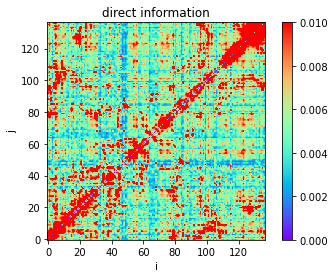

In [13]:
from inference_dca import direct_info_dca

# Verify that w is symmetric (sanity test)
print("Dimensions of w: ",w.shape)
di_file = "PF00186_DCA_di.npy"
if os.path.exists(di_file):
    DCA_di = np.load(di_file)
else:
    DCA_di = direct_info_dca(s0)
    np.save(di_file, DCA_di)

plt.title('direct information')
plt.imshow(DCA_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

### Plot DCA 

auc max: 4.7368421052631575 0.8936580554549336


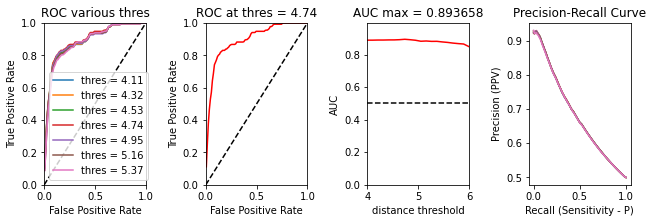

In [14]:
# find optimal threshold of distance
n = ct_thres.shape[0]

auc = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct,DCA_di,ct_thres[i])
    auc[i] = tp.sum()/tp.shape[0]

#np.savetxt('auc.dat',(ct_thres,auc),fmt='%f')    

#>
# plot at optimal threshold:
i0 = np.argmax(auc)
print('auc max:',ct_thres[i0],auc[i0])
p0,tp0,fp0 = tools.roc_curve(ct,DCA_di,ct_thres[i0])

iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')
for i in iplot:
    p,tp,fp = tools.roc_curve(ct,DCA_di,ct_thres[i])
    plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot2grid((1,4),(0,1))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0]))
plt.plot(fp0,tp0,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,4),(0,2))
plt.title('AUC max = %f' %(auc[i0]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc,'r-')
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
for i in iplot:
    p,tp,fp = tools.roc_curve(ct,di,ct_thres[i])
    try:
        plt.plot( p,tp / (tp + fp),label='thres = %3.1f'%ct_thres[i])
    except(RuntimeWarning):
        print("RuntimeWarning\ntp:",tp,"\nfp:",fp)
        plt.plot( p,tp,label='thres = %s'%ct_thres[i])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)

tools.hide_toggle()

## Compare Optimal DCA and ER (ct_thresh = 1.5 and 2. resp.)
* Taking the optimal threshold for each gives comparable accuracy
* ER Has higher accuracy for lower threshold

In [15]:
# find optimal threshold of distance for both DCA and ER
n = ct_thres.shape[0]

auc_DCA = np.zeros(n)
auc_ER = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct,DCA_di,ct_thres[i])
    auc_DCA[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct,ER_di,ct_thres[i])
    auc_ER[i] = tp.sum()/tp.shape[0]
    
i0_DCA = np.argmax(auc_DCA)
i0_ER = np.argmax(auc_ER)

print('DCA auc max:',ct_thres[i0_DCA],auc_DCA[i0_DCA])
p0_DCA,tp0_DCA,fp0_DCA = tools.roc_curve(ct,DCA_di,ct_thres[i0_DCA])
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct,ER_di,ct_thres[i0_ER])

tools.hide_toggle()

DCA auc max: 4.7368421052631575 0.8936580554549336
ER auc max: 4.7368421052631575 0.9287777641971491


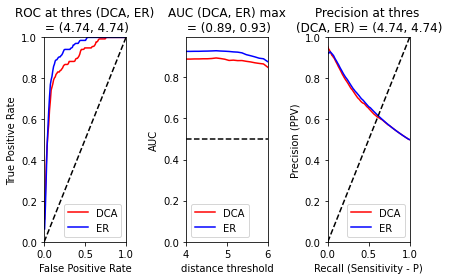

In [16]:
# Plot ROC for optimal DCA vs optimal ER
plt.subplot2grid((1,3),(0,0))
plt.title('ROC at thres (DCA, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
plt.plot(fp0_DCA,tp0_DCA,'r-',label="DCA")
plt.plot(fp0_ER,tp0_ER,'b-',label="ER")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC (DCA, ER) max\n = (%3.2f, %3.2f)' %(auc_DCA[i0_DCA], auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_DCA,'r-',label="DCA")
plt.plot(ct_thres,auc_ER,'b-',label="ER")
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision at thres \n(DCA, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
plt.plot( p0_DCA,tp0_DCA / (tp0_DCA + fp0_DCA),'r-',label='DCA')
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER),'b-',label='ER')
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])



plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()